In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

In [6]:
data_dir = Path("/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section4")

ds=ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])


label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
  label2id[class_name] = str(i)
  id2label[str(i)] = class_name

In [7]:
label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
  label2id[class_name] = str(i)
  id2label[str(i)] = class_name

In [8]:
import json
with open('/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody_new_2/label2id_section4.json', 'w') as fp:
    json.dump(label2id, fp)
    
with open('/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody_new_2/id2label_section4.json', 'w') as fp:
    json.dump(id2label, fp)

In [9]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=32, 
   collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, 
   num_workers=2)
model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class Classifier(pl.LightningModule):
   def __init__(self, model, lr: float = 2e-5, **kwargs): 
       super().__init__()
       self.save_hyperparameters('lr', *list(kwargs))
       self.model = model
       self.forward = self.model.forward 
       self.val_acc = Accuracy()
   def training_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"train_loss", outputs.loss)
       return outputs.loss
   def validation_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"val_loss", outputs.loss)
       acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"val_acc", acc, prog_bar=True)
       return outputs.loss
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), 
                        lr=self.hparams.lr,weight_decay = 0.00025)

In [10]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=10)
trainer.fit(classifier, train_loader, val_loader)

model.save_pretrained("/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody_new_2/section4")

Global seed set to 42
/home/orelit/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.605   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/orelit/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/orelit/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [12]:
model_path = '/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody/model_2'
SL_prod_model = ViTForImageClassification.from_pretrained(
         model_path,
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)

In [2]:
def prediction(img_path):
   im=Image.open(img_path)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   outputs = SL_prod_model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   tensor_result = outputs.logits.softmax(1)
   prob = torch.max(tensor_result)
   new_result = result.tolist() 
   for i in new_result:
     return(id2label[str(i)])

In [3]:
import os
test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/doody_all_test'

image_paths = []
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    image_paths.append(img)

In [13]:
import re
count = 0
correct = 0
for image in os.listdir(test_data_path):
    img = test_data_path +'/'+image
    pred= prediction(img)
    pred = pred[3:]
    print('Prediction : ',pred)
    test_label = image[image.rfind('/')+1:]
    real_class = test_label[0:13]
    print('Real Label : ',real_class)
    if real_class == pred:
        correct = correct +1
        print('Correctly Classified')
    else:
        print('Misclassified')
    count = count + 1
    print('.....................................')
    
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

# Multiple Models


In [14]:
import pandas as pd
import json

model_names = ['section1','section2','section3','section4']

data_dict = {}
for model_name in model_names:
    with open("/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody_new_2/id2label_{}.json"
                   .format(model_name), 'r') as fcc_file:
        data = json.load(fcc_file)
        
        data_dict["list_{}".format(model_name)] = []

        for key in data.keys():
            
            data_dict["list_{}".format(model_name)].append(data[key])
            

In [15]:
df = pd.DataFrame.from_dict(data_dict, orient='index').T
df

,list_section1,list_section2,list_section3,list_section4
0,7290000168173,7290000048185,0861432329,11111111
1,7290110328764,7290000522111,7290000307237,7290002824640
2,7290115259179,7290006492432,7290004122195,7290004127077
3,7290115259209,7290110324926,7290004131074,7290004127329
4,8715700115344,7290110328771,7290017217611,7290011923303
5,None,7290115259193,7290110328788,None
6,None,7290115259261,7290115259186,None
7,None,None,7290115259346,None


In [16]:
import os
import matplotlib
import shutil

test_data_path = '/home/orelit/Projects -Sathsara/Planigo/data/doody_test'

folder_names = []
for folder in os.listdir(test_data_path):
    folder_names.append(folder)

In [17]:
folder_names

['7290004127077',
 '7290011923303',
 '7290115259261',
 '7290004131074',
 '7290002824640',
 '7290004127329',
 '0861432329',
 '7290115259346',
 '7290110324926',
 '7290000307237',
 '7290115259193',
 '7290110328771',
 '7290110328764',
 '11111111',
 '7290115259179',
 '7290017217611',
 '7290004122195',
 '7290110328788',
 '7290115259186',
 '7290000168173',
 '7290000048185',
 '7290000522111']

In [18]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [19]:
def prediction(img_path,wine_model):
   im=Image.open(img_path)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   outputs = wine_model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   tensor_result = outputs.logits.softmax(1)
   prob = torch.max(tensor_result)
   new_result = result.tolist() 
   for i in new_result:
     return(id2label[str(i)])

In [20]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image, UnidentifiedImageError
import torch

count = 0
correct = 0

test_results = {}
result_counts = {}
model_list = []
folder_image_counts = []
folder_correct_counts = []

for folder in folder_names:
    prediction_list = []
    print('folder name :',folder)
    for column in df.columns:
        if folder  in df[column].unique():
            print(column)
            model  = column
    print('model name :',model)
    
    model_name = model[5:]
    print(model_name)
    
    data_dir = Path("/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/{}".format(model_name))
    print(data_dir)
    ds=ImageFolder(data_dir)
    
    label2id = {}
    id2label = {}
    for i, class_name in enumerate(ds.classes):
        label2id[class_name] = str(i)
        id2label[str(i)] = class_name
        
    model_path = '/home/orelit/Projects -Sathsara/Planigo/Models/VIT_Doody_new_2/{}'.format(model_name)
    wine_model = ViTForImageClassification.from_pretrained(
         model_path,
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)
    folder_correct_count = 0
    folder_image_count = 0
    for image in os.listdir(test_data_path+'/'+folder):
        if len(image)>=18:
            if '0861432329'in image:
                print('image name : ',image)
                img = test_data_path+'/'+folder +'/'+image
                pred= prediction(img,wine_model)
                print("predicted label : ",pred)
                test_label = image[image.rfind('/')+1:]
                real_class = test_label[0:10]
                real_class = real_class
                print('real label : ',real_class)
                folder_image_count = folder_image_count +1
                if real_class == pred:
                    correct = correct +1
                    folder_correct_count = folder_correct_count +1
                    print("Correctly classified")
                    prediction_list.append('Correctly Classified')
                else:
                    prediction_list.append(pred)
                count = count + 1
                print('..........................................')
                
            else:
                print('image name : ',image)
                img = test_data_path+'/'+folder +'/'+image
                pred= prediction(img,wine_model)
                print("predicted label : ",pred)
                test_label = image[image.rfind('/')+1:]
                real_class = test_label[0:13]
                real_class = real_class
                print('real label : ',real_class)
                folder_image_count = folder_image_count +1
                if real_class == pred:
                    correct = correct +1
                    folder_correct_count = folder_correct_count +1
                    print("Correctly classified")
                    prediction_list.append('Correctly Classified')
                else:
                    prediction_list.append(pred)
                count = count + 1
                print('..........................................')
       
        else:
            print('image name : ',image)
            img = test_data_path+'/'+folder +'/'+image
            pred= prediction(img,wine_model)
            print("predicted label : ",pred)
            test_label = image[image.rfind('/')+1:]
            real_class = test_label[0:8]
            real_class = real_class
            print('real label : ',real_class)
            folder_image_count = folder_image_count +1
            if real_class == pred:
                correct = correct +1
                folder_correct_count = folder_correct_count +1
                print("Correctly classified")
                prediction_list.append('Correctly Classified')
            else:
                prediction_list.append(pred)
            count = count + 1
            print('..........................................')
            
    model_list.append(model[5:])
    folder_correct_counts.append(folder_correct_count)
    folder_image_counts.append(folder_image_count)
    
    test_results[folder] = prediction_list
            
acc = correct/count
print("Number of images : ",count)
print("Number of correctly classified images : ",correct)
print("Accuray : ",acc)

folder name : 7290004127077
list_section4
model name : list_section4
section4
/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section4
image name :  7290004127077.jpeg
predicted label :  7290004127077
real label :  7290004127077
Correctly classified
..........................................
folder name : 7290011923303
list_section4
model name : list_section4
section4
/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section4
image name :  7290011923303.jpeg
predicted label :  7290011923303
real label :  7290011923303
Correctly classified
..........................................
folder name : 7290115259261
list_section2
model name : list_section2
section2
/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section2
image name :  7290115259261 (1).jpeg
predicted label :  7290115259261
real label :  7290115259261
Correctly classified
..........................................
image name :  7290115259261 (2).jpeg
predicted label :  7290115259261

predicted label :  7290110328764
real label :  7290110328764
Correctly classified
..........................................
folder name : 11111111
list_section4
model name : list_section4
section4
/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section4
image name :  11111111 (3).jpeg
predicted label :  11111111
real label :  11111111
Correctly classified
..........................................
image name :  11111111 (1).jpeg
predicted label :  11111111
real label :  11111111
Correctly classified
..........................................
image name :  11111111 (2).jpeg
predicted label :  11111111
real label :  11111111
Correctly classified
..........................................
folder name : 7290115259179
list_section1
model name : list_section1
section1
/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted/section1
image name :  7290115259179 (3).jpeg
predicted label :  7290115259179
real label :  7290115259179
Correctly classified
..................

In [21]:
result_counts = pd.DataFrame(list(zip(folder_names, model_list,folder_image_counts,folder_correct_counts)),
               columns =['folder_names', 'model_list','folder_image_count','folder_correct_count'])
result_counts

,folder_names,model_list,folder_image_count,folder_correct_count
0,7290004127077,section4,1,1
1,7290011923303,section4,1,1
2,7290115259261,section2,2,2
3,7290004131074,section3,1,1
4,7290002824640,section4,1,1
5,7290004127329,section4,3,3
6,0861432329,section3,9,9
7,7290115259346,section3,2,2
8,7290110324926,section2,1,1
9,7290000307237,section3,1,1


In [22]:
incorrect_list = []
for i,row in enumerate(result_counts['folder_names']):
    incorrect = result_counts['folder_image_count'][i] - result_counts['folder_correct_count'][i]
    incorrect_list.append(incorrect )
    
incorrect_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
result_counts['incorrectly classified'] = incorrect_list
result_counts

,folder_names,model_list,folder_image_count,folder_correct_count,incorrectly classified
0,7290004127077,section4,1,1,0
1,7290011923303,section4,1,1,0
2,7290115259261,section2,2,2,0
3,7290004131074,section3,1,1,0
4,7290002824640,section4,1,1,0
5,7290004127329,section4,3,3,0
6,0861432329,section3,9,9,0
7,7290115259346,section3,2,2,0
8,7290110324926,section2,1,1,0
9,7290000307237,section3,1,1,0


In [24]:
result_counts.to_csv('/home/orelit/Projects -Sathsara/Planigo/Test results/Doody Products/result_counts.csv')

In [25]:
results_df = pd.DataFrame.from_dict(test_results, orient='index').T

In [26]:
results_df.fillna("",inplace=True)
results_df

,7290004127077,7290011923303,7290115259261,7290004131074,7290002824640,7290004127329,0861432329,7290115259346,7290110324926,7290000307237,...,7290110328764,11111111,7290115259179,7290017217611,7290004122195,7290110328788,7290115259186,7290000168173,7290000048185,7290000522111
0,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,...,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,Correctly Classified,,Correctly Classified
1,,,Correctly Classified,,,Correctly Classified,Correctly Classified,Correctly Classified,,,...,Correctly Classified,Correctly Classified,Correctly Classified,,,Correctly Classified,Correctly Classified,,,Correctly Classified
2,,,,,,Correctly Classified,Correctly Classified,,,,...,,Correctly Classified,Correctly Classified,,,,Correctly Classified,,,
3,,,,,,,Correctly Classified,,,,...,,,,,,,Correctly Classified,,,
4,,,,,,,Correctly Classified,,,,...,,,,,,,,,,
5,,,,,,,Correctly Classified,,,,...,,,,,,,,,,
6,,,,,,,Correctly Classified,,,,...,,,,,,,,,,
7,,,,,,,Correctly Classified,,,,...,,,,,,,,,,
8,,,,,,,Correctly Classified,,,,...,,,,,,,,,,
9,,,,,,,,,,,...,,,,,,,,,,


In [27]:
results_df.to_csv('/home/orelit/Projects -Sathsara/Planigo/Test results/Doody Products/results.csv')

In [16]:
data_dir = '/home/orelit/Projects -Sathsara/Planigo/data/doody_new_splitted'

<AxesSubplot:>

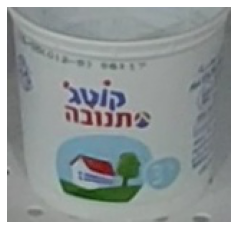

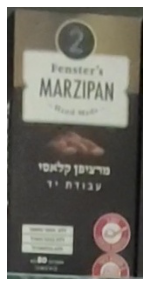

In [26]:
real_dir = data_dir + '/section2/7290004127077'
pred_dir = data_dir + '/section2/7290115259261'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

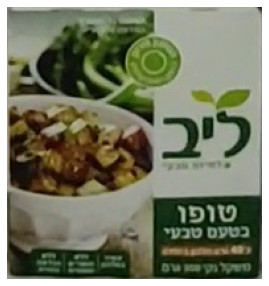

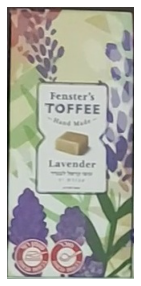

In [31]:
real_dir = data_dir + '/section1/7290011923303'
pred_dir = data_dir + '/section1/7290115259209'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

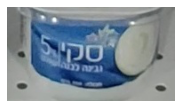

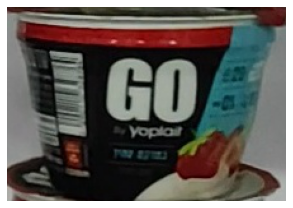

In [28]:
real_dir = data_dir + '/section1/7290002824640'
pred_dir = data_dir + '/section1/7290110328764'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

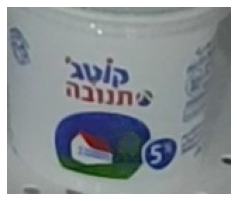

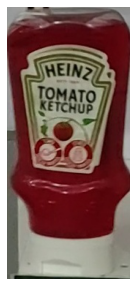

In [29]:
real_dir = data_dir + '/section1/7290004127329'
pred_dir = data_dir + '/section1/8715700115344'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))

<AxesSubplot:>

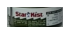

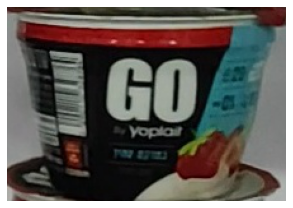

In [30]:
real_dir = data_dir + '/section1/11111111'
pred_dir = data_dir + '/section1/7290110328764'

real_path = Path(real_dir)
pred_path = Path(pred_dir)

real_items = get_image_files(real_path)
pred_items = get_image_files(pred_path)

im1 = PILImage.create(real_items[0])
im2 = PILImage.create(pred_items[0])

im1.show(); im2.show(figsize=(5,5))